# Capstone: Text Factorizing with NLP
## Thomas Ludlow

# 05 - Feature Engineering for RNN

This notebook will use the LDA model observation values to build the supervised Keras Recurrent Neural Net (RNN) model for measuring similarity between text passages.  These may be combined with other features, including:
- Spacy Word Vectors
- n-grams/n-graphs

**Libraries**

In [296]:
# Python Data Science
import re
import time
import numpy as np
import pandas as pd

# Natural Language Processing
import spacy
import gensim
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, ldamodel, ldamulticore, CoherenceModel

# Modeling Prep
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# Neural Net
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Override deprecation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

**Load Corpus Topic Values, Text Metadata**

In [297]:
book_df = pd.read_csv('./data/book_df.csv')
book_df.head()

,author,work,paragraph
0,Ani,Book of the Dead: The Papyrus of Ani,"""Homage to thee, Osiris, Lord of eternity, Kin..."
1,Ani,Book of the Dead: The Papyrus of Ani,"""Thou art the Great Chief, the first among thy..."
2,Ani,Book of the Dead: The Papyrus of Ani,"""Thou rollest up into the horizon, thou hast s..."
3,Ani,Book of the Dead: The Papyrus of Ani,"His sister [Isis] hath protected him, and hath..."
4,Ani,Book of the Dead: The Papyrus of Ani,A HYMN OF PRAISE TO RA WHEN HE RISETH IN THE E...


In [298]:
book_df.shape

(28805, 3)

In [299]:
book_df.author.value_counts()

Moses                              3274
Muhammad                           2854
Nietzsche, Friedrich               2421
Mill, John Stuart                  2046
Plato                              1911
Matthew, Mark, Luke, John          1767
Smith, Adam                        1389
Hobbes, Thomas                     1257
Kant, Immanuel                     1143
Spinoza, Baruch                    1138
Locke, John                         932
Rousseau, Jean-Jacques              833
Paine, Thomas                       819
Buddha, Siddhartha Guatama          769
Rand, Ayn                           679
Russell, Bertrand                   581
Confucius                           579
Sun Tzu                             558
Keynes, John Maynard                545
Gibran, Khalil                      461
James, William                      397
Hume, David                         355
Ani                                 343
Descartes, Rene                     329
Machiavelli, Nicolo                 260


In [300]:
c_values = pd.read_csv('./models/corpus_topic_df.csv')
c_values.head()

,0,1,2,3,4,5,6,7
0,0.186861,0.041349,0.023008,0.055623,0.196905,0.464256,0.000000,0.028641
1,0.076598,0.131217,0.043864,0.061473,0.379999,0.292917,0.000000,0.000000
2,0.163516,0.054710,0.057267,0.048800,0.278653,0.367343,0.016500,0.013212
3,0.060407,0.111848,0.052424,0.045420,0.497444,0.195880,0.014140,0.022437
4,0.080818,0.113798,0.029826,0.032807,0.209167,0.469323,0.032304,0.031957


In [301]:
c_values.shape

(28805, 8)

**Load LDA Model**

In [302]:
g_dict = Dictionary.load('./models/g_dict')

In [303]:
lda_model = gensim.models.LdaModel.load('./models/lda_model')

In [304]:
topics = lda_model.get_topics()

In [305]:
len(topics[3])

14452

In [306]:
lda_model.show_topics()

[(0,
  '0.053*"great" + 0.037*"good" + 0.027*"govern" + 0.023*"tax" + 0.019*"right" + 0.017*"pay" + 0.013*"valu" + 0.013*"peopl" + 0.013*"high" + 0.012*"revenu"'),
 (1,
  '0.034*"price" + 0.029*"labour" + 0.027*"land" + 0.026*"year" + 0.025*"money" + 0.022*"capit" + 0.017*"work" + 0.016*"silver" + 0.016*"time" + 0.015*"gold"'),
 (2,
  '0.028*"natur" + 0.018*"state" + 0.017*"differ" + 0.013*"in" + 0.012*"mean" + 0.010*"certain" + 0.009*"mind" + 0.009*"note" + 0.009*"knowledg" + 0.009*"particular"'),
 (3,
  '0.036*"bodi" + 0.033*"idea" + 0.030*"exist" + 0.026*"produc" + 0.022*"object" + 0.019*"emot" + 0.019*"conceiv" + 0.018*"gener" + 0.018*"kind" + 0.015*"thing"'),
 (4,
  '0.052*"man" + 0.025*"thing" + 0.017*"know" + 0.015*"far" + 0.014*"mind" + 0.013*"if" + 0.012*"great" + 0.012*"law" + 0.012*"life" + 0.011*"way"'),
 (5,
  '0.049*"god" + 0.045*"say" + 0.027*"thi" + 0.018*"come" + 0.018*"and" + 0.017*"bring" + 0.017*"armi" + 0.013*"read" + 0.013*"market" + 0.013*"rent"'),
 (6,
  '0.056*

# Set Topic Values with Labels for X and y

In [307]:
c_values.head()

,0,1,2,3,4,5,6,7
0,0.186861,0.041349,0.023008,0.055623,0.196905,0.464256,0.000000,0.028641
1,0.076598,0.131217,0.043864,0.061473,0.379999,0.292917,0.000000,0.000000
2,0.163516,0.054710,0.057267,0.048800,0.278653,0.367343,0.016500,0.013212
3,0.060407,0.111848,0.052424,0.045420,0.497444,0.195880,0.014140,0.022437
4,0.080818,0.113798,0.029826,0.032807,0.209167,0.469323,0.032304,0.031957


In [308]:
X = c_values.values
X

array([[ 0.18686105,  0.04134886,  0.02300789, ...,  0.46425605,
         0.        ,  0.02864126],
       [ 0.07659816,  0.13121691,  0.04386422, ...,  0.29291689,
         0.        ,  0.        ],
       [ 0.16351564,  0.05471003,  0.05726657, ...,  0.36734259,
         0.01649992,  0.01321248],
       ..., 
       [ 0.13513303,  0.02916335,  0.16097409, ...,  0.15160778,
         0.03047479,  0.05807627],
       [ 0.20160763,  0.05626975,  0.21267731, ...,  0.13800284,
         0.1097751 ,  0.03477832],
       [ 0.08393387,  0.03406325,  0.23115249, ...,  0.04116109,
         0.15295817,  0.03084495]])

In [309]:
X.shape

(28805, 8)

In [310]:
y_cat = pd.get_dummies(book_df['author'].str.lower()).values

In [311]:
author_columns = pd.get_dummies(book_df['author']).columns
author_columns

Index(['Ani', 'Aristotle', 'Buddha, Siddhartha Guatama', 'Confucius',
       'Descartes, Rene', 'Dewey, John', 'Gibran, Khalil', 'Hayek, Friedrich',
       'Hobbes, Thomas', 'Hume, David', 'James, William', 'Kant, Immanuel',
       'Keynes, John Maynard', 'Khyyam, Omar', 'Lao Tzu', 'Locke, John',
       'Machiavelli, Nicolo', 'Marx, Karl and Friedrich Engels',
       'Matthew, Mark, Luke, John', 'Mill, John Stuart', 'Moses', 'Muhammad',
       'Nietzsche, Friedrich', 'Paine, Thomas', 'Plato', 'Rand, Ayn',
       'Rousseau, Jean-Jacques', 'Russell, Bertrand', 'Smith, Adam',
       'Spinoza, Baruch', 'Sun Tzu', 'Thoreau, Henry David', 'Vyasa, Veda'],
      dtype='object')

In [312]:
y_cat

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

In [313]:
y_cat.shape

(28805, 33)

**Train Test Split**

In [251]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=.2, random_state=207, stratify=y_cat)

In [252]:
X_train.shape

(7379, 10)

In [253]:
X_test.shape

(1845, 10)

In [254]:
y_train.shape

(7379, 19)

In [255]:
y_test.shape

(1845, 19)

In [319]:
ss = StandardScaler()

# Full
X_sc = ss.fit_transform(X)

# Train Test Split
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

# Keras Feed-Forward Recurrent Neural Net (FFRNN)

**Shared Parameters**

In [326]:
dropout_pct = .25
dense_1_nodes = 128
dense_2_nodes = 64
epochs = 5

**Full Corpus**

In [327]:
model_full = Sequential()
model_full.add(Dense(X_sc.shape[0], input_dim=X_sc.shape[1], activation='relu'))
model_full.add(Dropout(dropout_pct))
model_full.add(Dense(dense_1_nodes, activation='relu'))
model_full.add(Dropout(dropout_pct))
model_full.add(Dense(dense_2_nodes, activation='relu'))
model_full.add(Dense(y_cat.shape[1], activation=None))
model_full.add(Activation(tf.nn.softmax))

In [328]:
model_full.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [329]:
early_stop_full = EarlyStopping(monitor='loss', min_delta=0, patience=20, verbose=1, mode='auto')

In [330]:
history_full = model_full.fit(X_sc, y_cat, 
                              epochs=epochs, 
                              batch_size=None, 
                              callbacks=[early_stop_full])

Epoch 1/5
28805/28805 [==============================] - 46s 2ms/step - loss: 2.2534 - acc: 0.3261
Epoch 2/5
28805/28805 [==============================] - 45s 2ms/step - loss: 2.0841 - acc: 0.3581
Epoch 3/5
28805/28805 [==============================] - 45s 2ms/step - loss: 2.0267 - acc: 0.3725
Epoch 4/5
28805/28805 [==============================] - 44s 2ms/step - loss: 2.0023 - acc: 0.3741
Epoch 5/5
28805/28805 [==============================] - 44s 2ms/step - loss: 1.9758 - acc: 0.3852


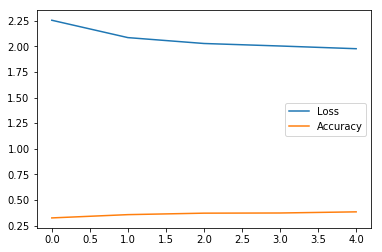

In [332]:
loss_vals = history_full.history['loss']
acc_vals = history_full.history['acc']
plt.plot(loss_vals, label='Loss')
plt.plot(acc_vals, label='Accuracy')
plt.legend()

**With Train Test Split**

In [263]:
model = Sequential()
model.add(Dense(X_train_sc.shape[0], input_dim=X_train_sc.shape[1], activation='relu'))
model.add(Dropout(dropout_pct))
model.add(Dense(dense_1_nodes, activation='relu'))
model.add(Dropout(dropout_pct))
model.add(Dense(dense_2_nodes, activation='relu'))
model.add(Dense(y_test.shape[1], activation=None))
model.add(Activation(tf.nn.softmax))

In [264]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [265]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

In [266]:
history = model.fit(X_train_sc, y_train, validation_data=(X_test_sc, y_test), epochs=epochs, batch_size=None, callbacks=[early_stop])

Train on 7379 samples, validate on 1845 samples
Epoch 1/100
7379/7379 [==============================] - 2s 321us/step - loss: 2.0234 - acc: 0.3757 - val_loss: 1.7449 - val_acc: 0.4602
Epoch 2/100
7379/7379 [==============================] - 2s 254us/step - loss: 1.7586 - acc: 0.4373 - val_loss: 1.6407 - val_acc: 0.4634
Epoch 3/100
7379/7379 [==============================] - 2s 255us/step - loss: 1.7067 - acc: 0.4480 - val_loss: 1.6080 - val_acc: 0.4802
Epoch 4/100
7379/7379 [==============================] - 2s 255us/step - loss: 1.6627 - acc: 0.4541 - val_loss: 1.6171 - val_acc: 0.4786
Epoch 5/100
7379/7379 [==============================] - 2s 258us/step - loss: 1.6356 - acc: 0.4662 - val_loss: 1.5569 - val_acc: 0.4889
Epoch 6/100
7379/7379 [==============================] - 2s 264us/step - loss: 1.6124 - acc: 0.4781 - val_loss: 1.5425 - val_acc: 0.4894
Epoch 7/100
7379/7379 [==============================] - 2s 261us/step - loss: 1.5931 - acc: 0.4787 - val_loss: 1.5437 - val_acc: 

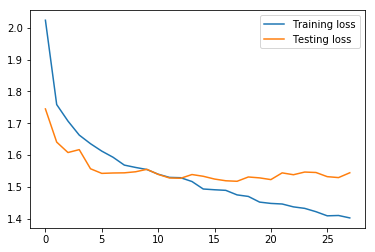

In [267]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

In [333]:
pred_full = model_full.predict_proba(X_sc)

In [268]:
pred_tt = model.predict_proba(X_sc)

In [287]:
pred_full

array([[  7.49956727e-01,   3.26737459e-09,   6.77966047e-03, ...,
          6.96241099e-04,   1.87124684e-01,   4.13147728e-12],
       [  4.76748854e-01,   4.97733676e-09,   6.69576898e-02, ...,
          2.29265042e-05,   3.58861327e-01,   1.58293881e-11],
       [  2.76144654e-01,   3.92453967e-06,   1.23365480e-03, ...,
          4.76089353e-03,   2.56318241e-01,   1.40280434e-07],
       ..., 
       [  2.61841980e-12,   1.81468113e-05,   5.07418774e-10, ...,
          3.10438431e-08,   3.66721742e-09,   9.25547004e-01],
       [  1.01107025e-06,   6.05173921e-03,   1.56163473e-08, ...,
          3.31622445e-08,   1.86844238e-06,   8.55630398e-01],
       [  5.54132248e-06,   3.13914730e-04,   5.87569912e-06, ...,
          8.60754426e-06,   4.99215384e-05,   8.13971639e-01]], dtype=float32)

In [270]:
pred_tt

array([[  5.07287025e-01,   3.88917385e-07,   3.67058441e-02, ...,
          4.03406518e-03,   2.70533711e-01,   5.69332860e-06],
       [  1.36374414e-01,   1.77412556e-08,   5.15071601e-02, ...,
          2.63525546e-03,   7.47745633e-01,   8.43287609e-08],
       [  2.04059899e-01,   7.03979640e-06,   1.13202892e-02, ...,
          9.18970723e-03,   2.82276452e-01,   3.14628793e-04],
       ..., 
       [  9.02390049e-04,   4.54310095e-04,   9.76243988e-04, ...,
          2.11941898e-02,   2.23878096e-03,   4.18472625e-02],
       [  1.05221348e-03,   9.29400045e-03,   3.05527123e-04, ...,
          3.35936755e-04,   8.35909601e-03,   1.39422849e-01],
       [  4.36278118e-04,   1.81460902e-02,   1.87679718e-04, ...,
          2.09522652e-04,   2.70190500e-02,   2.60629002e-02]], dtype=float32)

# Function `display_results`

In [271]:
def display_results(preds, doc_number, n_sims=y_pred.shape[1], thresh=0.01):
    print('Doc #:', doc_number)
    print('Author:', book_df.loc[doc_number]['author'], '\n')
    print('Text:', book_df.loc[doc_number]['paragraph'])
    print('\nPhilosophical Factors:\n')
    
    result_list = [(author_columns[i],preds[doc_number][i]) for i in range(y_cat.shape[1])]
    result_list.sort(key=lambda tup: tup[1], reverse=True)
    
    for j in range(n_sims):
        n_sp = 35 - len(result_list[j][0])
        if result_list[j][1] >= thresh:
            print('\t{}{}{}'.format(result_list[j][0],str(' '*n_sp),str(round(result_list[j][1], 3))))


In [334]:
display_results(pred_full, 7300)

Doc #: 7300
Author: Locke, John 

Text: 4. Distinct and confused, what. As a clear idea is that whereof the mind has such a full and evident perception, as it does receive from an outward object operating duly on a well-disposed organ, so a distinct idea is that wherein the mind perceives a difference from all other; and a confused idea is such an one as is not sufficiently distinguishable from another, from which it ought to be different. 5. Objection. If no idea be confused, but such as is not sufficiently distinguishable from another from which it should be different, it will be hard, may any one say, to find anywhere a confused idea. For, let any idea be as it will, it can be no other but such as the mind perceives it to be; and that very perception sufficiently distinguishes it from all other ideas, which cannot be other, i.e. different, without being perceived to be so. No idea, therefore, can be undistinguishable from another from which it ought to be different, unless you would

In [273]:
display_results(pred_tt, 7300)

Doc #: 7300
Author: Rousseau, Jean-Jacques 

Text: In proceeding thus, we shall not be obliged to make man a philosopher before he is a man. His duties toward others are not dictated to him only by the later lessons of wisdom and, so long as he does not resist the internal impulse of compassion, he will never hurt any other man, nor even any sentient being; except on those lawful occasions on which his own preservation is concerned and he is obliged to give himself the preference. By this method also we put an end to the time-honoured disputes concerning the participation of animals in natural law: for it is clear that, being destitute of intelligence and liberty, they cannot recognise that law; as they partake, however, in some measure of our nature, in consequence of the sensibility with which they are endowed, they ought to partake of natural rights so that mankind is subjected to a kind of obligation even toward the brutes. It appears, in fact, that if I am bound to do no injury to

# Test on new input

In [289]:
newpar = 'Only strong unified government can save from "the war of all against all"'

In [290]:
newpar_vec = ['only','strong','unified','government','can','save','from','war','all','against','all']

In [291]:
newpar_corp = g_dict.doc2bow(newpar_vec)
newpar_corp

[(177, 2),
 (256, 1),
 (1031, 1),
 (1121, 1),
 (1518, 1),
 (1826, 1),
 (2490, 1),
 (4784, 1)]

In [335]:
lda_model.get_document_topics(newpar_corp)

[(0, 0.16095294),
 (1, 0.038920309),
 (2, 0.14494805),
 (3, 0.074023783),
 (4, 0.28146976),
 (5, 0.16298768),
 (6, 0.10268444),
 (7, 0.034012996)]